In [1]:
import os
os.chdir(os.path.join(os.getcwd(),".."))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.metrics import confusion_matrix, classification_report

from tqdm.notebook import tqdm
import yaml

In [5]:
from tasks.nn.classifiers import build_model, keras_classifier

# Load Configuration

In [6]:
config_nn_path = os.path.join(os.getcwd(), "tasks", "project_configuration", "nn_tuning.yaml")
with open(config_nn_path, 'r') as stream:
    try:
        config_nn = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# Load Dataset

In [7]:
digits_mnist = keras.datasets.mnist

In [8]:
(train_X, train_y), (test_X, test_y) = digits_mnist.load_data()

In [9]:
test_y[:3]

array([7, 2, 1], dtype=uint8)

In [10]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_X.shape, train_y.shape))
print('Test: X=%s, y=%s' % (test_X.shape, test_y.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [11]:
test_y[:3]

array([7, 2, 1], dtype=uint8)

# Load the number of classes parameter to the configuration

In [12]:
config_nn["clf_params"]["n_classes"] = len(list(np.unique(train_y)))

In [13]:
config_nn["clf_params"]["n_classes"]

10

# Explore the Dataset

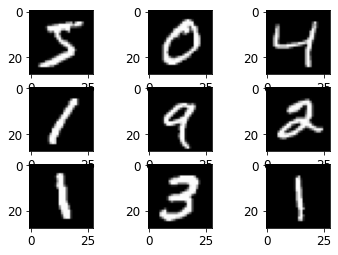

In [14]:
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [15]:
# reshape dataset to have a single channel
train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))
test_X = test_X.reshape((test_X.shape[0], 28, 28, 1))

In [16]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    
    return train_norm, test_norm

In [17]:
# prepare pixel data
train_X, test_X = prep_pixels(train_X, test_X)

In [18]:
train_X.shape

(60000, 28, 28, 1)

In [19]:
test_X.shape

(10000, 28, 28, 1)

# Create Classifier

In [20]:
model = build_model(n_classes=config_nn["clf_params"]["n_classes"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [21]:
keras.backend.clear_session()

In [22]:
# grid mode: "randomized", "gridsearch"
clf = keras_classifier(config=config_nn, clf_params=config_nn["clf_params"], 
                       param_grid=config_nn["param_distribs"], 
                       grid_mode="randomized") 

Classifier Parameters:
 {'epochs': 50, 'validation_split': 0.2, 'use_multiprocessing': True, 'shuffle': True, 'verbose': 1, 'n_classes': 10, 'build_fn': <function build_model at 0x7fcd21454f80>}


# Train the Classifier

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, History

In [24]:
callback_early_stopping = EarlyStopping(patience=20)

In [25]:
clf.fit(train_X, train_y, callbacks=[callback_early_stopping])

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/50
250/250 [==============================] - 3s 3ms/step - loss: 0.3338 - accuracy: 0.9064 - val_loss: 0.4111 - val_accuracy: 0.9151
Epoch 2/50
250/250 [==============================] - 1s 2ms/step - loss: 0.1505 - accuracy: 0.9610 - val_loss: 0.1478 - val_accuracy: 0.9656
Epoch 3/50
250/250 [==============================] - 1s 2ms/step - loss: 0.1133 - accuracy: 0.9714 - val_loss: 0.1031 - val_accuracy: 0.9740
Epoch 4/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0925 - accuracy: 0.9778 - val_loss: 0.0921 - val_accuracy: 0.9751
Epoch 5/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0777 - accuracy: 0.9818 - val_loss: 0.0841 - val_accuracy: 0.9779
Epoch 6/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0665 - accuracy: 0.9854 - val_loss: 0.0785 - val_accuracy: 0.9787
Epoch 7/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0585 - accura

Epoch 7/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0519 - accuracy: 0.9898 - val_loss: 0.0717 - val_accuracy: 0.9809
Epoch 8/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0454 - accuracy: 0.9912 - val_loss: 0.0705 - val_accuracy: 0.9812
Epoch 9/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0407 - accuracy: 0.9931 - val_loss: 0.0674 - val_accuracy: 0.9820
Epoch 10/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0364 - accuracy: 0.9946 - val_loss: 0.0663 - val_accuracy: 0.9819
Epoch 11/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0329 - accuracy: 0.9955 - val_loss: 0.0643 - val_accuracy: 0.9825
Epoch 12/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0295 - accuracy: 0.9960 - val_loss: 0.0629 - val_accuracy: 0.9833
Epoch 13/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0266 - accuracy: 0.9972 - val_loss: 0.0628 - val_accuracy: 0.9822
Ep

250/250 [==============================] - 1s 2ms/step - loss: 0.0289 - accuracy: 0.9965 - val_loss: 0.0731 - val_accuracy: 0.9780
Epoch 14/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0264 - accuracy: 0.9972 - val_loss: 0.0724 - val_accuracy: 0.9784
Epoch 15/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0244 - accuracy: 0.9974 - val_loss: 0.0712 - val_accuracy: 0.9783
Epoch 16/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0224 - accuracy: 0.9979 - val_loss: 0.0700 - val_accuracy: 0.9789
Epoch 17/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0210 - accuracy: 0.9981 - val_loss: 0.0700 - val_accuracy: 0.9793
Epoch 18/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0190 - accuracy: 0.9985 - val_loss: 0.0690 - val_accuracy: 0.9787
Epoch 19/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0182 - accuracy: 0.9989 - val_loss: 0.0688 - val_accuracy: 0.9785
Epoch 20/50

125/125 [==============================] - 0s 3ms/step - loss: 0.0354 - accuracy: 0.9947 - val_loss: 0.0683 - val_accuracy: 0.9816
Epoch 20/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0333 - accuracy: 0.9950 - val_loss: 0.0673 - val_accuracy: 0.9826
Epoch 21/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0319 - accuracy: 0.9956 - val_loss: 0.0666 - val_accuracy: 0.9822
Epoch 22/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0303 - accuracy: 0.9962 - val_loss: 0.0656 - val_accuracy: 0.9825
Epoch 23/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0287 - accuracy: 0.9964 - val_loss: 0.0650 - val_accuracy: 0.9831
Epoch 24/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 0.9969 - val_loss: 0.0645 - val_accuracy: 0.9829
Epoch 25/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0260 - accuracy: 0.9973 - val_loss: 0.0641 - val_accuracy: 0.9831
Epoch 26/50

125/125 [==============================] - 0s 3ms/step - loss: 0.0290 - accuracy: 0.9965 - val_loss: 0.0665 - val_accuracy: 0.9822
Epoch 26/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0277 - accuracy: 0.9972 - val_loss: 0.0656 - val_accuracy: 0.9821
Epoch 27/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0263 - accuracy: 0.9972 - val_loss: 0.0650 - val_accuracy: 0.9825
Epoch 28/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0251 - accuracy: 0.9977 - val_loss: 0.0649 - val_accuracy: 0.9821
Epoch 29/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0244 - accuracy: 0.9978 - val_loss: 0.0647 - val_accuracy: 0.9822
Epoch 30/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0230 - accuracy: 0.9981 - val_loss: 0.0639 - val_accuracy: 0.9821
Epoch 31/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.9982 - val_loss: 0.0633 - val_accuracy: 0.9824
Epoch 32/50

125/125 [==============================] - 0s 3ms/step - loss: 0.0201 - accuracy: 0.9986 - val_loss: 0.0737 - val_accuracy: 0.9795
Epoch 32/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0194 - accuracy: 0.9985 - val_loss: 0.0735 - val_accuracy: 0.9800
Epoch 33/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0184 - accuracy: 0.9990 - val_loss: 0.0729 - val_accuracy: 0.9799
Epoch 34/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9991 - val_loss: 0.0727 - val_accuracy: 0.9795
Epoch 35/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0173 - accuracy: 0.9990 - val_loss: 0.0720 - val_accuracy: 0.9799
Epoch 36/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9991 - val_loss: 0.0719 - val_accuracy: 0.9793
Epoch 37/50
125/125 [==============================] - 0s 3ms/step - loss: 0.0160 - accuracy: 0.9992 - val_loss: 0.0714 - val_accuracy: 0.9797
Epoch 38/50

375/375 [==============================] - 1s 2ms/step - loss: 0.0059 - accuracy: 0.9999 - val_loss: 0.0525 - val_accuracy: 0.9854
Epoch 38/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0528 - val_accuracy: 0.9856
Epoch 39/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0527 - val_accuracy: 0.9855
Epoch 40/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0527 - val_accuracy: 0.9859
Epoch 41/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0051 - accuracy: 0.9999 - val_loss: 0.0526 - val_accuracy: 0.9858
Epoch 42/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0050 - accuracy: 0.9999 - val_loss: 0.0528 - val_accuracy: 0.9856
Epoch 43/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9853
Epoch 44/50

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcd2133cd10>,
                   param_distributions={'batch_size': [128, 256]}, verbose=2)

In [26]:
clf.best_params_

{'batch_size': 128}

In [27]:
clf.best_score_

0.9828333258628845

In [28]:
clf.best_estimator_

In [29]:
clf.score(test_X, test_y)

79/79 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.9850


0.9850000143051147

In [30]:
model = clf.best_estimator_.model
model

In [31]:
# evaluate model on test dataset
loss, acc = model.evaluate(test_X, test_y, verbose=1)
print('> %.3f' % (acc * 100.0))

313/313 [==============================] - 1s 2ms/step - loss: 0.0453 - accuracy: 0.9850
> 98.500


In [32]:
clf.cv_results_

{'mean_fit_time': array([28.43425679, 16.86969916]),
 'std_fit_time': array([0.68047108, 0.09445085]),
 'mean_score_time': array([0.23741539, 0.15652164]),
 'std_score_time': array([0.00366893, 0.00205301]),
 'param_batch_size': masked_array(data=[128, 256],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 128}, {'batch_size': 256}],
 'split0_test_score': array([0.98334998, 0.98245001]),
 'split1_test_score': array([0.98234999, 0.97915   ]),
 'split2_test_score': array([0.98280001, 0.98009998]),
 'mean_test_score': array([0.98283333, 0.98056666]),
 'std_test_score': array([0.00040892, 0.00138705]),
 'rank_test_score': array([1, 2], dtype=int32)}

# Train and Evaluate the best Classifier

In [33]:
params = clf.best_params_

In [34]:
params

{'batch_size': 128}

In [35]:
keras.backend.clear_session()

In [36]:
model = build_model(n_classes=config_nn["clf_params"]["n_classes"])

In [37]:
history = model.fit(train_X,
                    train_y,
                    validation_split=config_nn["clf_params"]["validation_split"],
                    use_multiprocessing=config_nn["clf_params"]["use_multiprocessing"],
                    shuffle=config_nn["clf_params"]["shuffle"],
                    epochs=config_nn["clf_params"]["epochs"],
                    verbose = config_nn["clf_params"]["verbose"], 
                    batch_size=params['batch_size'])

Epoch 1/50
375/375 [==============================] - 1s 2ms/step - loss: 0.3018 - accuracy: 0.9164 - val_loss: 0.2495 - val_accuracy: 0.9502
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 0.1302 - accuracy: 0.9667 - val_loss: 0.1180 - val_accuracy: 0.9693
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0976 - accuracy: 0.9759 - val_loss: 0.0965 - val_accuracy: 0.9740
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0777 - accuracy: 0.9814 - val_loss: 0.0872 - val_accuracy: 0.9769
Epoch 5/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0650 - accuracy: 0.9849 - val_loss: 0.0802 - val_accuracy: 0.9779
Epoch 6/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0560 - accuracy: 0.9876 - val_loss: 0.0747 - val_accuracy: 0.9793
Epoch 7/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0487 - accuracy: 0.9894 - val_loss: 0.0725 - val_accuracy: 0.9792
Epoch 

In [38]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 375}

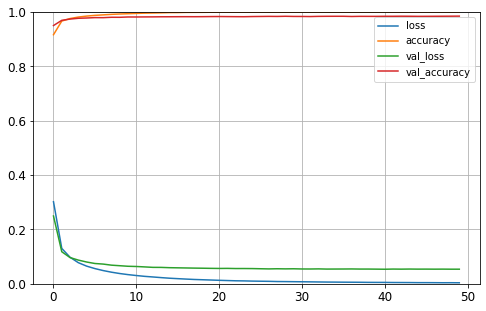

In [39]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [40]:
# evaluate model on test dataset
loss, acc = model.evaluate(test_X, test_y, verbose=1)
print('> %.3f' % (acc * 100.0))

313/313 [==============================] - 0s 1ms/step - loss: 0.0512 - accuracy: 0.9835
> 98.350


In [41]:
predictions = np.argmax(model.predict(test_X, verbose=1), axis=-1)

313/313 [==============================] - 0s 750us/step


In [42]:
predictions.shape

(10000,)

In [43]:
predictions[:3]

array([7, 2, 1])

In [44]:
print(confusion_matrix(test_y, predictions))

[[ 975    0    3    0    1    0    0    1    0    0]
 [   0 1128    4    0    0    1    1    1    0    0]
 [   1    1 1019    1    1    0    0    6    2    1]
 [   0    0    2  998    0    5    0    3    2    0]
 [   0    0    0    1  968    0    2    0    2    9]
 [   3    0    1    5    0  878    5    0    0    0]
 [   6    2    2    1    1    4  937    1    3    1]
 [   0    3   10    2    2    1    0 1004    2    4]
 [   6    0    2    2    2    1    2    3  952    4]
 [   3    3    0    3   11    4    0    4    5  976]]


In [45]:
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

